In [1]:
import numpy as np
import copy
import scipy.io
mat = scipy.io.loadmat('/Users/nikitakocherin/Downloads/BlackBoxData.mat')
x = mat['x'][0]
y = mat['y'][0]
x = (x / np.linalg.norm(x))
y = (y / np.linalg.norm(y))

In [2]:
def generate_first_monom_dict(I, x):
    def generate_first_mon(bias, x):
        if bias == 0:
                return x
        base = np.zeros(len(x), dtype='complex')
        if bias < 0:
            for i in range(-bias, len(x)):
                base[i] = x[i + bias]
        elif bias > 0:
            for i in range(len(x) - bias):
                base[i] = x[i + bias]
        return base
    result = []
    for i in range(-I, I + 1):
        result.append(generate_first_mon(i, x))
    return result

In [3]:
#Функция для генерации словаря мономов, из которых потом будет состоять каждый элемент настоящего словаря
# I -- максимальный модуль сдвига(bias)
# |d|
#нужно брать модуль при генерации
def generate_monom_dict(I, D, x):
    def generate_mon(bias, degree, x):
        if bias == 0:
            return np.power(np.absolute(x), degree)
        base = np.zeros(len(x), dtype='complex')
        if bias < 0:
            for i in range(-bias, len(x)):
                base[i] = x[i + bias]
        elif bias > 0:
            for i in range(len(x) - bias):
                base[i] = x[i + bias]
        return np.power(np.absolute(base), degree)
    result = []
    for i in range(-I, I + 1):
        for j in range(D + 1):
            result.append(generate_mon(i, j, x))
    return result

#M -- количество мономов в одном элементе словаря, не считая первого с нулевой степенью
def generate_real_dict(I, D, M, x):
    monom_dict = generate_monom_dict(I, D, x)
    result = []
    def recursive_generate(monom_dict, deep, x):
        if deep == 1:
            return monom_dict
        else:
            to_mult = recursive_generate(monom_dict, deep - 1, x)
            result = []
            first_mon = monom_dict
            for i in first_mon:
                for j in to_mult:
                    result.append(i * j)
            return result
    first_mon = generate_first_monom_dict(I, x)
    to_mult = recursive_generate(monom_dict, M, x)
    for i in first_mon:
        for j in to_mult:
            k = i * j
            k = k / np.linalg.norm(k)
            result.append(k)
    return result 

In [22]:
#y -- приближаем с помощью x
#u -- остаток, изначальный остаток -- y
#
def approximate(x, y, I, D, M, flag=True):
    my_dict = generate_real_dict(I, D, M, x)
    u_n = y
    iter = 0
    v_arr = []
    v_norm = []
    norm_u_n_prev = 0
    u_n_prev = copy.deepcopy(u_n)
    while(np.linalg.norm(u_n) > 0.01 and iter < 1000):
        v_norm.append(np.linalg.norm(u_n))
        if abs(np.linalg.norm(u_n) - norm_u_n_prev) < 0.0000001:
            break
        norm_u_n_prev = np.linalg.norm(u_n)
        v_n1 = None
        val = 0
        for i in my_dict:
            s = np.absolute(np.vdot(u_n, i))
            nor = abs(s)
            if nor > val:
                v_n1 = i
                val = nor
        h_n1_wave = copy.deepcopy(v_n1)
        if flag:
            for i in v_arr:
                #print("iter", iter)
                #print(np.vdot(v_n1, i), np.vdot(i, v_n1))
                h_n1_wave = h_n1_wave - np.vdot(i, v_n1) * i
        h_n1 = h_n1_wave / np.linalg.norm(h_n1_wave)
        v_arr.append(h_n1)
        u_n = u_n - np.vdot(h_n1, u_n) * h_n1 #поменял
        iter += 1
        if iter % 20 == 0:
            print(np.linalg.norm(u_n))
    print(np.linalg.norm(u_n), "iter:", iter)
    return v_norm

In [13]:
def generate_first_mon(bias, x):
        if bias == 0:
                return x
        base = np.zeros(len(x), dtype='complex')
        if bias < 0:
            for i in range(-bias, len(x)):
                base[i] = x[i + bias]
        elif bias > 0:
            for i in range(len(x) - bias):
                base[i] = x[i + bias]
        return base

In [ ]:
def generate_monom_dict(I, D, x):
    def generate_mon(bias, degree, x):
        if bias == 0:
            return np.power(np.absolute(x), degree)
        base = np.zeros(len(x), dtype='complex')
        if bias < 0:
            for i in range(-bias, len(x)):
                base[i] = x[i + bias]
        elif bias > 0:
            for i in range(len(x) - bias):
                base[i] = x[i + bias]
        return np.power(np.absolute(base), degree)
    result = []
    for i in range(-I, I + 1):
        for j in range(D + 1):
            result.append(generate_mon(i, j, x))
    return result

In [14]:
#M -- количество мономов в одном элементе словаря, не считая первого с нулевой степенью
def generate_real_dict_subset(I, D, M, x, bias):
    monom_dict = generate_monom_dict(I, D, x)
    result = []
    def recursive_generate(monom_dict, deep, x):
        if deep == 1:
            return monom_dict
        else:
            to_mult = recursive_generate(monom_dict, deep - 1, x)
            result = []
            first_mon = monom_dict
            for i in first_mon:
                for j in to_mult:
                    result.append(i * j)
            return result
    first_mon = generate_first_mon(bias, x)
    to_mult = recursive_generate(monom_dict, M, x)
    for j in to_mult:
        k = first_mon * j
        k = k / np.linalg.norm(k)
        result.append(k)
    return result 

In [24]:
#y -- приближаем с помощью x
#u -- остаток, изначальный остаток -- y
#
def approximate_v2(x, y, I, D, M, flag=True):
    my_dict_vect = []
    for i in range(-I, I+1):
        my_dict_vect.append(generate_real_dict_subset(I, D, M, x, i))
    u_n = y
    iter = 0
    v_arr = []
    v_norm = []
    norm_u_n_prev = 0
    u_n_prev = copy.deepcopy(u_n)
    while(np.linalg.norm(u_n) > 0.01 and iter < 1000):
        v_norm.append(np.linalg.norm(u_n))
        if abs(np.linalg.norm(u_n) - norm_u_n_prev) < 0.0000001:
            break
        norm_u_n_prev = np.linalg.norm(u_n)
        v_n1 = None
        val = 0
        for my_dict in my_dict_vect:
            v_n1 = None
            val = 0
            for i in my_dict:
                s = np.absolute(np.vdot(u_n, i))
                nor = abs(s)
                if nor > val:
                    v_n1 = i
                    val = nor
            h_n1_wave = copy.deepcopy(v_n1)
            if flag:
                for i in v_arr:
                    #print("iter", iter)
                    #print(np.vdot(v_n1, i), np.vdot(i, v_n1))
                    h_n1_wave = h_n1_wave - np.vdot(i, v_n1) * i
            h_n1 = h_n1_wave / np.linalg.norm(h_n1_wave)
            v_arr.append(h_n1)
            u_n = u_n - np.vdot(h_n1, u_n) * h_n1 #поменял
        iter += 1
        if iter % 20 == 0:
            print(np.linalg.norm(u_n))
    print(np.linalg.norm(u_n), "iter:", iter)
    return v_norm

In [26]:
%%time
v_222 = approximate(x, y, 2, 2, 2)

0.06538489239939564
0.05583293902304306
0.05003677189411938
0.04739865688126172
0.04217663780605666
0.03645991573276225
0.03470083535171343
0.03308249723319386
0.03222761634072152
0.03144936901175746
0.031121265956730707
0.030736246638154663
0.03059678039165769
0.030519390722423607
0.030508246876823138 iter: 286
CPU times: user 1min 51s, sys: 1min 9s, total: 3min 1s
Wall time: 4min 46s


In [27]:
%%time
v_222_supergreedy = approximate_v2(x, y, 2, 2, 2)

0.03765028227198311
0.031364520747358536
0.03049785979158311
0.030496353552486286 iter: 62
CPU times: user 51.2 s, sys: 31.9 s, total: 1min 23s
Wall time: 2min 44s


In [28]:
%%time
v_222_no_ort = approximate(x, y, 2, 2, 2, flag=False)

0.11128126586900108
0.09986014158463716
0.09112624265971817
0.08432935343427764
0.07912715457580209
0.07534130826442093
0.0721439803203222
0.06970033730010385
0.0677223543414777
0.06601428977989882
0.06472392071466573
0.06362069957869074
0.06276534423336066
0.06207089993450143
0.06141572873603459
0.060882033775814214
0.06039673008660622
0.05996638716602934
0.05959800770138612
0.05927130799168378
0.05897077652276462
0.058696413752660756
0.058453792771223465
0.05824620593844652
0.05803193499831493
0.05786417341667071
0.05768235431255373
0.057508926719268494
0.05735231130961205
0.057197438929515926
0.05705520238566508
0.05692938826627151
0.05680881924333436
0.056689674305829295
0.05657366476928492
0.056472003637721355
0.05636068454679526
0.056258314005887274
0.05616160028583652
0.0560693297509504
0.05598388823851755
0.05589366287824777
0.0558123893228947
0.055733111747252
0.055651876814320114
0.05558588652423488
0.05551115994261018
0.055443543445916864
0.05537750093379218
0.05531771566351

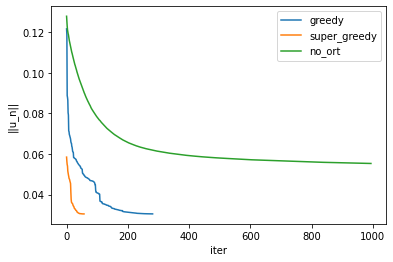

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots() 
ax.plot(v_222[5:], label="greedy")
ax.plot(v_222_supergreedy[5:], label="super_greedy")
ax.plot(v_222_no_ort[5:], label="no_ort")

ax.set_xlabel('iter')
ax.set_ylabel('||u_n||')
ax.legend()